In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation,NMF
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [2]:
df = pd.read_csv('/content/Youtube_comments.csv')
df.head()

<ipython-input-2-afd71d3ce536>:1: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/Youtube_comments.csv')


,Unnamed: 0,video_id,comment_text,likes,replies
0,0,XpVt6Z1Gjjo,Logan Paul it's yo big day ‼️‼️‼️,4,0
1,1,XpVt6Z1Gjjo,I've been following you from the start of your...,3,0
2,2,XpVt6Z1Gjjo,Say hi to Kong and maverick for me,3,0
3,3,XpVt6Z1Gjjo,MY FAN . attendance,3,0
4,4,XpVt6Z1Gjjo,trending 😉,3,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 691374 entries, 0 to 691373
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Unnamed: 0    691374 non-null  int64 
 1   video_id      691374 non-null  object
 2   comment_text  691374 non-null  object
 3   likes         691374 non-null  object
 4   replies       691374 non-null  object
dtypes: int64(1), object(4)
memory usage: 26.4+ MB


# **Data Cleaning**

## **Changing data type**

In [4]:
df['likes'] = pd.to_numeric(df['likes'], errors='coerce').fillna(0).astype('int64')
df['replies'] = pd.to_numeric(df['replies'], errors='coerce').fillna(0).astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 691374 entries, 0 to 691373
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Unnamed: 0    691374 non-null  int64 
 1   video_id      691374 non-null  object
 2   comment_text  691374 non-null  object
 3   likes         691374 non-null  int64 
 4   replies       691374 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 26.4+ MB


## **Removing emojies, special charactars, URLs and stopwords**


In [5]:
nltk.download('stopwords')
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = text.lower()
    stop_words = set(stopwords.words('english'))

    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text.strip()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
df.loc[:, 'comment_text'] = df['comment_text'].apply(clean_text)
df.head()

,Unnamed: 0,video_id,comment_text,likes,replies
0,0,XpVt6Z1Gjjo,logan paul yo big day,4,0
1,1,XpVt6Z1Gjjo,ive following start vine channel seen 365 vlogs,3,0
2,2,XpVt6Z1Gjjo,say hi kong maverick,3,0
3,3,XpVt6Z1Gjjo,fan attendance,3,0
4,4,XpVt6Z1Gjjo,trending,3,0


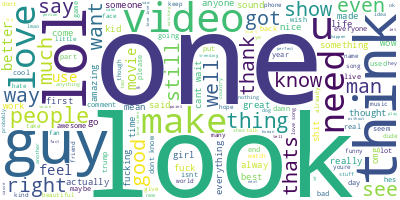

In [7]:
from wordcloud import WordCloud
long_string = ','.join(list(df['comment_text'].values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

We can see that the most repeated words in the data set are: **One**, **Look**, **Guy**, **Video**, **Lol**, **Need**.

# **Sentiment analysis**

In [8]:
from textblob import TextBlob

def get_sentiment(text):
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

In [9]:
df['sentiment'] = df['comment_text'].apply(get_sentiment)
df.head()

,Unnamed: 0,video_id,comment_text,likes,replies,sentiment
0,0,XpVt6Z1Gjjo,logan paul yo big day,4,0,neutral
1,1,XpVt6Z1Gjjo,ive following start vine channel seen 365 vlogs,3,0,neutral
2,2,XpVt6Z1Gjjo,say hi kong maverick,3,0,neutral
3,3,XpVt6Z1Gjjo,fan attendance,3,0,neutral
4,4,XpVt6Z1Gjjo,trending,3,0,neutral


In [10]:
df['sentiment'].value_counts()

,count
sentiment,
neutral,298991
positive,286988
negative,105395


# **Topic Modeling Using LDA**

In [11]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['comment_text'])

In [12]:
lda_model = LatentDirichletAllocation(n_components=10, random_state=42)
lda_topics = lda_model.fit_transform(X)

### Top 10 topics

In [13]:
def print_topics(model, vectorizer, n_top_words):
    for idx, topic in enumerate(model.components_):
        print(f"Topic #{idx + 1}:")
        print([(vectorizer.get_feature_names_out()[i], topic[i])
                      for i in topic.argsort()[:-n_top_words - 1:-1]])
    print()

print_topics(lda_model, vectorizer, 10)

Topic #1:
[('wtf', 896.0384789939036), ('best', 886.2299721240361), ('que', 544.4637395747327), ('lit', 507.5821744751594), ('im', 487.8650017275514), ('trump', 446.5353626475769), ('la', 431.42022819044735), ('like', 413.2468019717582), ('legend', 394.37454150028924), ('sad', 359.2430385803332)]
Topic #2:
[('love', 8305.313711948475), ('song', 2961.343358904909), ('voice', 892.2792414040939), ('like', 890.8885412361328), ('video', 848.2855762940882), ('im', 786.1295664745651), ('videos', 754.9398236819685), ('hair', 675.2386270583526), ('omg', 650.1809942509267), ('guys', 634.4316678586108)]
Topic #3:
[('cute', 1592.286128029041), ('fake', 1026.0058595384899), ('like', 808.9825608999113), ('perfect', 759.0965660333181), ('news', 633.1757197980123), ('im', 587.0078681309819), ('love', 557.3821503454086), ('people', 525.7549126794081), ('dead', 515.3456014070388), ('whats', 511.08421592908616)]
Topic #4:
[('beautiful', 3153.0211292381373), ('great', 2000.0301580295213), ('nice', 1976.23

In [14]:
feature_names = vectorizer.get_feature_names_out()

def get_top_words(model, feature_names, n_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append(" ".join(top_words))
    return topics

# Define number of top words to identify topics
n_top_words = 5
topic_names = get_top_words(lda_model, feature_names, n_top_words)

# Print topic names
for idx, topic in enumerate(topic_names):
    print(f"Topic {idx}: {topic}")

# Assign topic names to each comment
df['topic'] = lda_topics.argmax(axis=1)
df['topic_name'] = df['topic'].apply(lambda x: topic_names[x])

Topic 0: wtf best que lit im
Topic 1: love song voice like video
Topic 2: cute fake like perfect news
Topic 3: beautiful great nice video love
Topic 4: awesome iphone yes im like
Topic 5: trending amazing good fuck funny
Topic 6: wow dont like people god
Topic 7: like video rip music love
Topic 8: cool omg love like makeup
Topic 9: lol im like hi love


In [15]:
df.head()

,Unnamed: 0,video_id,comment_text,likes,replies,sentiment,topic,topic_name
0,0,XpVt6Z1Gjjo,logan paul yo big day,4,0,neutral,7,like video rip music love
1,1,XpVt6Z1Gjjo,ive following start vine channel seen 365 vlogs,3,0,neutral,7,like video rip music love
2,2,XpVt6Z1Gjjo,say hi kong maverick,3,0,neutral,9,lol im like hi love
3,3,XpVt6Z1Gjjo,fan attendance,3,0,neutral,1,love song voice like video
4,4,XpVt6Z1Gjjo,trending,3,0,neutral,5,trending amazing good fuck funny


In [16]:
df['topic_name'] = df['topic_name'].str.split().str[0]
df.head()

,Unnamed: 0,video_id,comment_text,likes,replies,sentiment,topic,topic_name
0,0,XpVt6Z1Gjjo,logan paul yo big day,4,0,neutral,7,like
1,1,XpVt6Z1Gjjo,ive following start vine channel seen 365 vlogs,3,0,neutral,7,like
2,2,XpVt6Z1Gjjo,say hi kong maverick,3,0,neutral,9,lol
3,3,XpVt6Z1Gjjo,fan attendance,3,0,neutral,1,love
4,4,XpVt6Z1Gjjo,trending,3,0,neutral,5,trending


# **Analysis**

**Distrubtion of sentiment**

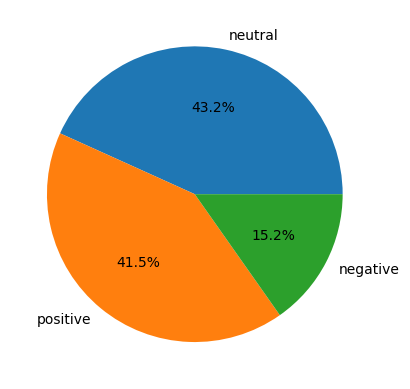

In [ ]:
x = df['sentiment'].value_counts()
y = x.index
plt.pie(x, labels=y, autopct='%1.1f%%')
plt.show()

In [ ]:
df['topic_name'].value_counts()

,count
topic_name,
trending,87640
awesome,80252
wow,71503
love,69320
like,68170
wtf,65316
cool,63633
lol,62779
cute,62556


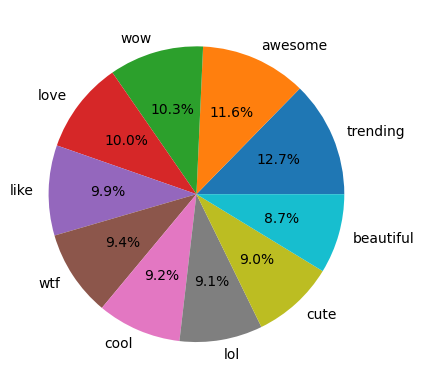

In [ ]:
x = df['topic_name'].value_counts()
y = x.index
plt.pie(x, labels=y, autopct='%1.1f%%')
plt.show()

**Correlation between likes and replies**

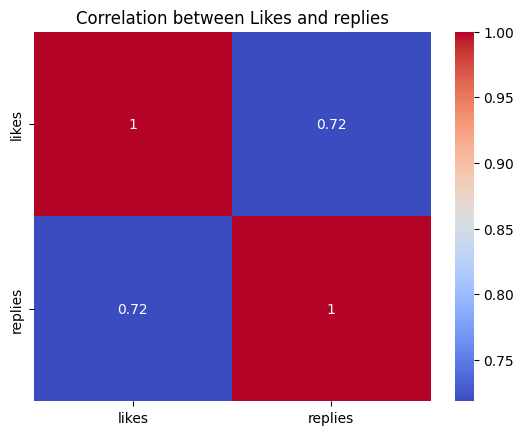

In [ ]:
correlation = df[['likes', 'replies']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation between Likes and replies')
plt.show()

**Correlation between likes/replies and sentiment**

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df['sentiment_encoded'] = le.fit_transform(df['sentiment'])
df['topic_encoded'] = le.fit_transform(df['topic_name'])

In [ ]:
df.head()

,Unnamed: 0,video_id,comment_text,likes,replies,sentiment,topic,topic_name,sentiment_encoded,topic_encoded
0,0,XpVt6Z1Gjjo,logan paul yo big day,4,0,neutral,7,like,1,4
1,1,XpVt6Z1Gjjo,ive following start vine channel seen 365 vlogs,3,0,neutral,7,like,1,4
2,2,XpVt6Z1Gjjo,say hi kong maverick,3,0,neutral,9,lol,1,5
3,3,XpVt6Z1Gjjo,fan attendance,3,0,neutral,1,love,1,6
4,4,XpVt6Z1Gjjo,trending,3,0,neutral,5,trending,1,7


**Correlation between sentiment and topic**

In [17]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df['sentiment'], df['topic'])

chi2, p, dof, expected = chi2_contingency(contingency_table)
n = contingency_table.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
print(f"Cramér's V: {cramers_v}")

Cramér's V: 0.15213167931513832


In [20]:
sentiment_grouped = df.groupby('sentiment')[['likes', 'replies']].sum()
print(sentiment_grouped)
topic_grouped = df.groupby('topic_name')[['likes', 'replies']].sum().sort_values(by='likes', ascending=False)
print(topic_grouped)

             likes  replies
sentiment                  
negative    654815    48265
neutral    1486838    96036
positive   1882954   149908
             likes  replies
topic_name                 
awesome     545923    49420
wtf         533038    26218
lol         489439    36528
like        465950    28231
love        423975    21921
cute        394668    28326
beautiful   364651    27307
trending    360988    35105
cool        236963    18816
wow         209012    22337


In [ ]:
df['replies'].value_counts()[500]

71

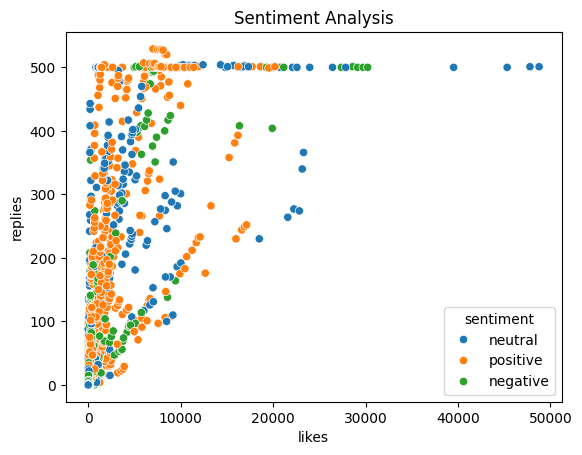

In [ ]:
sns.scatterplot(data=df, x='likes', y='replies', hue='sentiment')
plt.title('Sentiment Analysis')
plt.show()

**Topic Analysis**

In [ ]:
import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(lda_model, X, vectorizer, mds='tsne')
pyLDAvis.display(panel)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
